In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from pathlib import Path
from collections import Counter

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import dill
import pandas as pd
import polars as pl
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import GroupKFold

import lightgbm as lgb

import pytorch_lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from tasks.data.dataset.mappers import EntityEncoder
from tasks.jobs import Splitter

In [26]:
from otto_utils import *
from otto_features import *
from otto_candidates_covisit import *
from otto_lgbm_utils import *
from otto_implicit import *

# Load data

## valid

In [4]:
# load
val_df_train = pl.read_parquet(VALIDATION_PATH / "train.parquet", use_pyarrow=True)
val_df_valid_input = pl.read_parquet(VALIDATION_PATH / "valid.parquet", use_pyarrow=True)
val_df_valid_targets = pl.read_parquet(VALIDATION_PATH / "test_labels.parquet", use_pyarrow=True)

# Features

## valid

### user features

In [5]:
df = val_df_valid_input.unique().sort(["session", "ts"])

In [6]:
df_user_action_stats_features = user_action_stats_features(df)

In [ ]:
# не добавляют в качестве
# df_user_time_distr_features = user_time_distr_features(df)

In [7]:
df_user_last_type_actions = (
    df
    .groupby(["session", "type"])
    .agg([
        pl.last("aid")
    ])
    .pivot(values="aid", index="session", columns="type")
    .rename({
        "0": "last_click_aid",
        "1": "last_cart_aid",
        "2": "last_order_aid",
    })
    .sort("session")
)

In [11]:
df_user_action_stats_features.write_parquet("__features__valid__user_action_stats_v1.parquet")
df_user_time_distr_features.write_parquet("__features__valid__user_time_distr_v1.parquet")
df_user_last_type_actions.write_parquet("__features__valid__user_last_type_actions_v1.parquet")

### user item features

In [8]:
df = val_df_valid_input.unique().sort(["session", "ts"])

In [9]:
df_user_item_history_features = user_item_history_features(df)

In [12]:
df_user_item_history_features.write_parquet("__features__valid__user_item_history_v1.parquet")

In [80]:
df_user_item_history_features

session,aid,user_item_log_recency_score,user_item_type_weighted_log_recency_score,user_item_is_in_history
i64,i64,f64,f64,i32
11107743,731062,0.464086,0.464086,1
11107743,1243310,1.071773,1.071773,1
11107744,1637748,0.624505,0.624505,1
11107744,1556644,1.319508,1.053251,1
11107744,220086,0.071773,0.071773,1
11107745,670066,1.558329,1.558329,1
11107745,1682122,1.355143,1.355143,1
11107745,770581,0.071773,0.071773,1
11107746,795232,1.0,1.0,1


### item features

In [10]:
df = pl.concat([val_df_train, val_df_valid_input]).unique().sort(["session", "ts"])

In [11]:
df_item_action_stats_features = item_action_stats_features(df)

In [ ]:
# не добавляют в качестве
# df_item_time_distr_features = item_time_distr_features(df)

In [12]:
df_item_n_sess_multiple_action = item_n_sessions_with_repeated_actions(df)

In [53]:
%env PYTHONHASHSEED=1
from otto_word2vec import *

w2vec = Word2Vec.load("__valid__word2vec_window=10_negative=20.w2v")

env: PYTHONHASHSEED=1


In [66]:
df_w2v_embeddings = pl.from_numpy(w2vec.wv.vectors).with_row_count()
df_w2v_embeddings.columns = ["aid"] + [f"w2v_emb_{i}"
                                       for i in range(w2vec.wv.vectors.shape[1])]
df_w2v_embeddings = df_w2v_embeddings.with_column(pl.col("aid").cast(pl.Int64))

In [16]:
df_item_action_stats_features.write_parquet("__features__valid__item_action_stats_v1.parquet")
df_item_time_distr_features.write_parquet("__features__valid__item_time_distr_v1.parquet")
df_item_n_sess_multiple_action.write_parquet("__features__valid__item_n_sess_multiple_action_v1.parquet")
df_w2v_embeddings.write_parquet("__features__valid__item_w2v_embeddings_window=10_negative=20.parquet")

In [76]:
import umap

In [77]:
plane_mapper = umap.UMAP(random_state=42).fit(w2vec.wv.vectors)

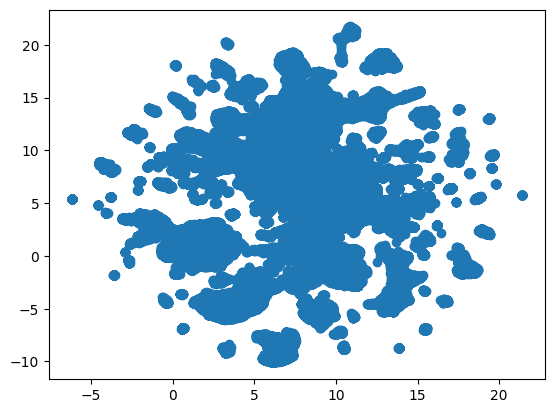

In [78]:
plt.scatter(plane_mapper.embedding_.T[0], plane_mapper.embedding_.T[1])

In [79]:
df_item_action_stats_features

aid,item_lifetime_days,item_n_actions,item_n_uniq_users,item_buys_rate,item_uniq_orders,item_uniq_clicks,item_uniq_carts,or_cnt,cl_cnt,ca_cnt,item_ca_cl_ratio,item_or_cl_ratio,item_or_ca_ratio
i64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64
939783,19.237157,10,1,0.4,1,6,1,1,7,2,0.285714,0.142857,0.5
1116066,22.81035,152,1,0.111842,3,67,10,3,138,11,0.07971,0.021739,0.272727
1151657,7.856166,4,1,0.0,0,4,0,0,4,0,0.0,0.0,0.0
1244819,10.320586,6,1,0.0,0,2,0,0,6,0,0.0,0.0,0.0
1349730,13.388732,31,1,0.677419,4,9,7,5,15,11,0.733333,0.333333,0.454545
369374,22.658771,36,1,0.166667,1,21,4,1,31,4,0.129032,0.032258,0.25
472024,20.660854,42,1,0.071429,0,22,3,0,39,3,0.076923,0.0,0.0
434047,26.84842,111,1,0.351351,11,52,16,11,83,17,0.204819,0.13253,0.647059
13531,18.132783,24,1,0.125,0,18,3,0,21,3,0.142857,0.0,0.0


# Candidates

In [13]:
df = val_df_valid_input.unique().sort(["session", "ts"])

In [14]:
# Use top X for clicks, carts and orders
clicks_th = 15
carts_th  = 20
orders_th = 20

def get_top(df, th):
    return (
        df
        .with_column(pl.lit(1).alias("ones"))
        .with_column(pl.col("ones").cumsum().over("aid").alias("rank"))
        .filter(pl.col("rank") <= th)
    )

TOPK_RECOMMEND = 20
TOPK_RERANK = 40

## valid

In [15]:
carts_orders = pl.read_parquet("__valid__covisit_carts_orders_all_v3.parquet")
buys2buys = pl.read_parquet("__valid__covisit_buys2buys_all_v4.parquet")
clicks = pl.read_parquet("__valid__covisit_clicks_all_v3.parquet")

In [16]:
carts_orders_top = get_top(carts_orders, carts_th)
buys2buys_top = get_top(buys2buys, orders_th)
clicks_top = get_top(clicks, clicks_th)

In [17]:
top_clicks = df.filter(pl.col("type") == 0)["aid"].value_counts(sort=True)[:TOPK_RECOMMEND]["aid"].to_list()
top_carts = df.filter(pl.col("type") == 1)["aid"].value_counts(sort=True)[:TOPK_RECOMMEND]["aid"].to_list()
top_orders = df.filter(pl.col("type") == 2)["aid"].value_counts(sort=True)[:TOPK_RECOMMEND]["aid"].to_list()

In [18]:
covisit_rec = CovisitationRecommender(
    df_top_k_buys=carts_orders_top,
    df_top_k_buy2buy=buys2buys_top,
    df_top_k_clicks=clicks_top,
    top_carts=top_carts,
    top_orders=top_orders,
    top_clicks=top_clicks,
)

## Carts

In [20]:
act_type = "carts"

### prepare target

In [21]:
df_act_target = (
    val_df_valid_targets
    .filter(pl.col("type") == act_type)
    .join(val_df_valid_input.select(["session"]).unique(), on="session", how="inner")
    .drop("type")
    .explode("ground_truth")
    .with_column(pl.lit(1).alias("target"))
    .rename({"ground_truth": "aid"})
)

### generate candidates

In [23]:
test_df = (
    df
    .join(df_act_target.select(["session"]).unique(), on="session", how="inner")
    .unique().sort(["session", "ts"])
)
test_sessions_dict = test_df.groupby('session').agg([pl.list("aid"), pl.list("type")])
test_sessions_dict = dict(zip(
    test_sessions_dict["session"].to_list(),
    tuple(zip(test_sessions_dict["aid"].to_list(), test_sessions_dict["type"].to_list()))
))

#### covisit top200

In [24]:
candidates_dict = {
    "session": [],
    "type": [],
    "candidates": [],
    "rank": [],
}

types = ["clicks", "carts", "orders"]
# types = ["orders"]
topk = TOPK_RERANK * 5
# topk = TOPK_RERANK

for session_id, (session_aid_list, session_type_list) in tqdm(test_sessions_dict.items()):
    rec_items_clicks = covisit_rec.recommend_clicks(session_aid_list, session_type_list, topk)
    rec_items_carts = covisit_rec.recommend_carts(session_aid_list, session_type_list, topk)
    rec_items_buys = covisit_rec.recommend_buys(session_aid_list, session_type_list, topk)

    candidates = [rec_items_clicks, rec_items_carts, rec_items_buys]
#     candidates = [rec_items_buys]
    ranks = [
        np.arange(1, len(rec_items) + 1).tolist()
        for rec_items in candidates
    ]
    
    candidates_dict["session"].extend([session_id] * len(types))
    candidates_dict["type"].extend(types)
    candidates_dict["candidates"].extend(candidates)
    candidates_dict["rank"].extend(ranks)

df_candidates = pl.DataFrame(candidates_dict)

100%|██████████| 265206/265206 [00:35<00:00, 7424.62it/s]


#### implicit i2i k=100 top100

In [25]:
# calc recency
# reweight types
#   orders > carts > clicks
#   decrease items with no repeated actions

df_type_weights = pl.DataFrame({"type": [0, 1, 2], "weight": [1, 3, 6]})

df = (
    pl.concat([val_df_train, val_df_valid_input]).unique().sort(["session", "ts"])
    .select([
        pl.col('*'),
        pl.col('session').cumcount().reverse().over('session').alias('action_num_reverse_chrono'),
        pl.col('session').count().over('session').alias('session_length'),
    ])
)
linear_interpolation = 0.1 + ((1-0.1) / (df['session_length']-1)) * (df['session_length']-df['action_num_reverse_chrono']-1)
df = (
    df
    .with_columns(pl.Series(2**linear_interpolation - 1).alias('log_recency_score')).fill_nan(1)
    .join(df_type_weights, on="type")
    .join(df_item_n_sess_multiple_action, on="aid", how="left")
    .with_column((pl.col("weight") * pl.col("log_recency_score")).alias("weight_recency"))
    .groupby(["session", "aid"])
    .agg([
        pl.sum("weight_recency").alias("weight")
    ])
)

In [27]:
train_data = make_sparse_matrix(df)

In [28]:
from implicit.nearest_neighbours import CosineRecommender

i2i = CosineRecommender(K=100)
i2i.fit(train_data)

  0%|          | 0/1855603 [00:00<?, ?it/s]

In [29]:
candidates_dict = {
    "session": [],
    "aid": [],
    "i2i_score": [],
#     "i2i_rank": [],
}

types = ["clicks", "carts", "orders"]
topk = 100

test_users = list(test_sessions_dict.keys())
b_sz = 1000
recs = []
for test_session_start in tqdm(range(0, len(test_users), b_sz)):
    test_sessions = test_users[test_session_start : test_session_start + b_sz]
    rec_items, scores = i2i.recommend(
        test_sessions, user_items=train_data[test_sessions], N=topk,
        filter_already_liked_items=False, recalculate_user=False
    )
#     ranks = [
#         np.arange(1, len(score) + 1).tolist()
#         for score in scores
#     ]

    candidates_dict["session"].extend(test_sessions)
    candidates_dict["aid"].extend(rec_items.tolist())
    candidates_dict["i2i_score"].extend(scores.tolist())
#     candidates_dict["i2i_rank"].extend(ranks)
    
df_candidates_i2i_orders = pl.DataFrame(candidates_dict)

100%|██████████| 266/266 [00:25<00:00, 10.52it/s]


### before reranking submission result

In [83]:
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = TOPK_RECOMMEND

for session_id, (session_aid_list, session_type_list) in tqdm(test_sessions_dict.items()):
    rec_items_clicks = covisit_rec.recommend_clicks(session_aid_list, session_type_list, topk)
    rec_items_carts = covisit_rec.recommend_carts(session_aid_list, session_type_list, topk)
    rec_items_buys = covisit_rec.recommend_buys(session_aid_list, session_type_list, topk)

    session_types = [f"{session_id}_{t}" for t in types]
    labels_list = [
        " ".join(str(aid) for aid in rec_items)
        for rec_items in [rec_items_clicks, rec_items_carts, rec_items_buys]
    ]
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

df_submission_valid = pl.DataFrame(submission_dict)

100%|██████████| 1303355/1303355 [01:50<00:00, 11818.07it/s]


In [86]:
# before reranking
valid_metrics_stats = calc_valid_score(df_submission_valid, topk=TOPK_RECOMMEND)

validation score: 0.5553397377087794
recall per type: type
carts    0.3932
clicks   0.5155
orders   0.6430
dtype: float64


# Reranker

In [30]:
df_candidates_for_orders_all = (
    df_candidates
    .join(
        df_act_target.select(["session"]).unique(),
        on="session", how="inner"
    )
    .filter(pl.col("type") == "orders")
    .drop("type")
    .explode(["candidates", "rank"])
    .rename({"candidates": "aid", "rank": "rank_orders"})
    .join(
        (
            df_candidates
            .join(
                df_act_target.select(["session"]).unique(),
                on="session", how="inner"
            )
            .filter(pl.col("type") == "carts")
            .drop("type")
            .explode(["candidates", "rank"])
            .rename({"candidates": "aid", "rank": "rank_carts"})
        ),
        on=["session", "aid"],
        how="outer"
    )
    .join(
        (
            df_candidates
            .join(
                df_act_target.select(["session"]).unique(),
                on="session", how="inner"
            )
            .filter(pl.col("type") == "clicks")
            .drop("type")
            .explode(["candidates", "rank"])
            .rename({"candidates": "aid", "rank": "rank_clicks"})
        ),
        on=["session", "aid"],
        how="outer"
    )
    .join(
        (
            df_candidates_i2i_orders
            .join(
                df_act_target.select(["session"]).unique(),
                on="session", how="inner"
            )
            .explode(["aid", "i2i_score"])
        ),
        on=["session", "aid"],
        how="outer"
    )
    .fill_null(999)
)

In [31]:
df_candidates_for_orders_all

session,aid,rank_orders,rank_carts,rank_clicks,i2i_score
i64,i64,i64,i64,i64,f64
11107744,1556644,1,1,1,2.037527
11107744,1637748,2,2,2,0.824638
11107744,220086,3,3,3,0.615195
11107744,830498,4,4,4,0.485181
11107744,959553,5,5,7,0.094365
11107744,813313,7,6,8,0.189515
11107744,107209,11,7,10,0.220429
11107744,263196,19,8,5,0.128509
11107744,1510820,16,9,6,0.0653


In [32]:
# candidates i2i + covisit all

df_stage_2_dataset_train = (
    df_candidates_for_orders_all
    .join(df_act_target, on=["session", "aid"], how="left")  # if using rank column as a feature
    .join(df_act_target.select(["session"]).unique(), on="session", how="inner")
    .sort("session")
    .unique(subset=["session", "aid"], keep="last").fill_null(0)
)

In [33]:
df_stage_2_dataset_train["target"].value_counts()

target,counts
i32,u32
0,53822032
1,261052


### join features

In [34]:
df_stage_2_dataset_train = (
    df_stage_2_dataset_train
    .join(df_user_last_type_actions, on="session", how="left")
    .join(
        carts_orders.rename({"weight": "user_last_click_aid_carts_orders_weight"}),
        left_on=["aid", "last_click_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        buys2buys.rename({"weight": "user_last_click_aid_buy2buy_weight"}),
        left_on=["aid", "last_click_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        clicks.rename({"weight": "user_last_click_aid_click_weight"}),
        left_on=["aid", "last_click_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        carts_orders.rename({"weight": "user_last_cart_aid_carts_orders_weight"}),
        left_on=["aid", "last_cart_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        buys2buys.rename({"weight": "user_last_cart_aid_buy2buy_weight"}),
        left_on=["aid", "last_cart_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        clicks.rename({"weight": "user_last_cart_aid_click_weight"}),
        left_on=["aid", "last_cart_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        carts_orders.rename({"weight": "user_last_order_aid_carts_orders_weight"}),
        left_on=["aid", "last_order_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        buys2buys.rename({"weight": "user_last_order_aid_buy2buy_weight"}),
        left_on=["aid", "last_order_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        clicks.rename({"weight": "user_last_order_aid_click_weight"}),
        left_on=["aid", "last_order_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .drop(["last_click_aid", "last_cart_aid", "last_order_aid"])
    .fill_null(0)
)

In [35]:
df_stage_2_dataset_train = (
    df_stage_2_dataset_train
    .join(df_user_action_stats_features, on="session", how="left")
#     .join(df_user_time_distr_features, on="session", how="left")
    .join(df_item_action_stats_features, on="aid", how="left")
#     .join(df_item_time_distr_features, on="aid", how="left") # лишний признак
    .join(df_item_n_sess_multiple_action, on="aid", how="left")
    .join(df_user_item_history_features, on=["session", "aid"], how="left")
    .join(df_w2v_embeddings, on="aid", how="left")
    .sort("session")
    .fill_null(0)
)

In [63]:
df_w2v_embeddings

aid,w2v_emb_0,w2v_emb_1,w2v_emb_2,w2v_emb_3,w2v_emb_4,w2v_emb_5,w2v_emb_6,w2v_emb_7,w2v_emb_8,w2v_emb_9,w2v_emb_10,w2v_emb_11,w2v_emb_12,w2v_emb_13,w2v_emb_14,w2v_emb_15,w2v_emb_16,w2v_emb_17,w2v_emb_18,w2v_emb_19,w2v_emb_20,w2v_emb_21,w2v_emb_22,w2v_emb_23,w2v_emb_24,w2v_emb_25,w2v_emb_26,w2v_emb_27,w2v_emb_28,w2v_emb_29,w2v_emb_30,w2v_emb_31
u32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0.043853,-0.614668,-0.391733,-1.166041,-0.799034,1.336721,0.381332,-0.051241,0.002287,0.121607,-0.848532,0.789753,1.928542,-0.209502,-1.362072,-0.048887,-0.201528,0.276412,0.037386,0.433012,-0.15135,-1.20497,0.7382,0.520457,0.649247,-1.820427,-1.148956,0.029788,0.032581,0.279415,0.149373,-0.268206
1,0.298325,0.131811,-1.040933,-0.129763,0.176279,0.369598,0.358124,-0.634744,0.632033,-0.165039,-1.034062,0.467031,1.42021,-0.457659,-0.685651,0.923591,-0.679838,0.458732,0.122785,-0.253355,-0.46888,-0.623026,-0.360678,0.624729,0.480032,-1.672616,-1.547431,-0.462195,0.173561,0.499173,0.279856,0.359014
2,-0.350798,0.879298,-0.40177,-0.18092,-0.64268,-0.051196,-0.419335,-0.410218,0.845292,-0.232793,-0.446258,1.234468,0.780641,-0.336228,-1.214086,0.396169,-0.410803,0.39954,0.13747,0.054555,-1.14034,-0.323996,-0.059131,0.907972,1.002851,-1.865441,-1.262602,0.424264,0.850204,0.055104,0.389652,-0.029032
3,0.475019,0.476558,-0.971202,-0.11768,0.265327,0.37242,0.20262,-0.706933,0.646512,-0.0246,-1.269613,0.346366,1.307918,-0.344878,-0.338889,0.791407,-0.636601,0.25264,-0.104375,-0.35091,-0.507916,-0.746166,-0.580822,0.099015,0.772847,-1.609018,-1.552069,-0.064333,0.097087,0.412574,0.358363,0.233939
4,0.269939,0.079861,-1.028718,-0.306859,0.123606,0.197071,0.445715,-0.59883,0.710363,-0.280221,-0.992727,0.423917,1.383599,-0.47222,-0.827537,0.977875,-0.794251,0.410409,0.107098,-0.096967,-0.484407,-0.584384,-0.427441,0.801553,0.397305,-1.731256,-1.527047,-0.637409,0.206146,0.402497,0.1381,0.439969
5,0.25942,1.101685,-0.153267,0.435401,0.563335,0.411169,-0.438673,-0.513789,-0.013394,0.776794,-0.226001,0.180391,1.155306,-1.143508,-0.56485,0.107157,-0.333331,0.245774,0.613596,-0.389176,0.417237,-1.272688,-0.695435,0.869872,0.676744,-0.966044,-0.915075,0.565391,0.621684,0.338393,-0.221201,0.577165
6,0.096224,0.2598,-0.336962,-0.267871,-0.297231,-0.216745,0.877149,-0.260748,1.301125,-0.074504,-1.215221,0.211267,0.888167,-0.801855,-0.98728,0.688695,-0.811243,-0.552611,-0.118217,-0.206824,-0.832874,-0.855609,-0.559224,0.630269,0.986462,-0.907212,-0.670331,-0.531506,0.404356,0.504285,0.143378,0.401224
7,-0.423856,1.085582,0.038004,0.674619,0.378925,0.89447,-0.131611,-0.645991,0.14768,0.633458,-0.620582,0.595027,1.197788,-1.062664,-0.79334,0.03669,-0.457053,0.110261,0.635186,-0.583477,0.567274,-1.394168,-0.533829,0.771328,0.571044,-0.443273,-0.614222,0.150341,0.798155,0.070894,0.037992,0.675124
8,0.252777,-0.024317,-0.636122,-0.276076,-0.069523,0.059146,0.308783,-0.41669,0.419411,0.083246,-1.240163,-0.657588,0.819021,-0.881633,-0.729045,0.546998,-0.193639,0.630276,-0.137257,-0.502717,-0.500261,-1.409703,-0.840256,0.368968,0.87216,-1.533162,-0.518382,-0.049548,0.431901,0.270234,0.12378,-0.166064


In [69]:
df_stage_2_dataset_train = (
    df_stage_2_dataset_train
    .join(df_w2v_embeddings, on="aid", how="left")
    .sort("session")
    .fill_null(0)
)

In [70]:
df_stage_2_dataset_train.head(2)

session,aid,rank_orders,rank_carts,rank_clicks,i2i_score,target,user_last_click_aid_carts_orders_weight,user_last_click_aid_buy2buy_weight,user_last_click_aid_click_weight,user_last_cart_aid_carts_orders_weight,user_last_cart_aid_buy2buy_weight,user_last_cart_aid_click_weight,user_last_order_aid_carts_orders_weight,user_last_order_aid_buy2buy_weight,user_last_order_aid_click_weight,user_lifetime_days,user_n_actions,user_n_uniq_items,user_buys_rate,user_uniq_clicks,user_uniq_carts,user_uniq_orders,cl_cnt,ca_cnt,or_cnt,user_ca_cl_ratio,user_or_cl_ratio,user_or_ca_ratio,item_lifetime_days,item_n_actions,item_n_uniq_users,item_buys_rate,item_uniq_orders,item_uniq_clicks,item_uniq_carts,or_cnt_right,...,item_n_sess_multi_carts,item_n_sess_multi_buys,user_item_log_recency_score,user_item_type_weighted_log_recency_score,user_item_is_in_history,w2v_emb_0,w2v_emb_1,w2v_emb_2,w2v_emb_3,w2v_emb_4,w2v_emb_5,w2v_emb_6,w2v_emb_7,w2v_emb_8,w2v_emb_9,w2v_emb_10,w2v_emb_11,w2v_emb_12,w2v_emb_13,w2v_emb_14,w2v_emb_15,w2v_emb_16,w2v_emb_17,w2v_emb_18,w2v_emb_19,w2v_emb_20,w2v_emb_21,w2v_emb_22,w2v_emb_23,w2v_emb_24,w2v_emb_25,w2v_emb_26,w2v_emb_27,w2v_emb_28,w2v_emb_29,w2v_emb_30,w2v_emb_31
i64,i64,i64,i64,i64,f64,i32,f64,i32,f64,f64,i32,f64,f64,i32,f64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,u32,u32,f64,u32,u32,u32,u32,...,u32,u32,f64,f64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
11107744,1556644,1,1,1,2.037527,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.000726,4,3,0.25,3,1,0,3,1,0,0.333333,0.0,0.0,27.581874,374,1,0.165775,11,192,34,12,...,3,1,1.319508,1.053251,1,0.693865,0.22317,-0.332749,-0.504098,-0.587602,1.574919,-0.578092,0.243056,0.355006,0.287241,-0.210381,-0.643189,0.889284,-0.407237,-1.258894,0.139029,-1.303749,-0.329157,0.49955,-0.4426,0.250465,-0.667886,-0.331436,0.000694,0.119434,-0.007328,-0.453632,1.322308,-0.175771,0.867142,-0.052315,0.144646
11107744,1637748,2,2,2,0.824638,0,31.5,2,19.063351,31.5,2,19.063351,0.0,0,0.0,0.000726,4,3,0.25,3,1,0,3,1,0,0.333333,0.0,0.0,26.390133,69,1,0.057971,0,46,4,0,...,0,0,0.624505,0.624505,1,0.020813,-0.450126,0.354581,0.38568,0.458712,0.476034,-0.264486,-0.492572,0.760455,0.403444,-0.302943,0.468948,-0.292035,-0.501846,-0.564208,1.496797,-1.110397,0.558129,-0.570215,-0.772563,0.149273,-0.558431,-0.432006,1.123545,-0.456436,-1.262917,-0.283321,-0.125956,-1.159313,0.457858,-0.789284,-0.022579


### train

In [37]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
#     'objective': 'binary',
    'objective': 'lambdarank',
    'metric': '"None"',
    'eval_at': 20,
#     'metric': {'auc', 'binary_logloss'},
#     'min_data_in_leaf': 256, 
#     'num_leaves': 63,
    'max_depth': 7,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'device': 'gpu',
    'verbose': -1,
    'num_threads': 40,
}

#### candidates covisit top200 all types - orders, carts, clicks + i2i top100, features w2v embeddings (CV carts 0.4134) BEST!

In [71]:
feature_cols = df_stage_2_dataset_train.drop(["session", "aid", "target"]).columns
feature_cols

['rank_orders',
 'rank_carts',
 'rank_clicks',
 'i2i_score',
 'user_last_click_aid_carts_orders_weight',
 'user_last_click_aid_buy2buy_weight',
 'user_last_click_aid_click_weight',
 'user_last_cart_aid_carts_orders_weight',
 'user_last_cart_aid_buy2buy_weight',
 'user_last_cart_aid_click_weight',
 'user_last_order_aid_carts_orders_weight',
 'user_last_order_aid_buy2buy_weight',
 'user_last_order_aid_click_weight',
 'user_lifetime_days',
 'user_n_actions',
 'user_n_uniq_items',
 'user_buys_rate',
 'user_uniq_clicks',
 'user_uniq_carts',
 'user_uniq_orders',
 'cl_cnt',
 'ca_cnt',
 'or_cnt',
 'user_ca_cl_ratio',
 'user_or_cl_ratio',
 'user_or_ca_ratio',
 'item_lifetime_days',
 'item_n_actions',
 'item_n_uniq_users',
 'item_buys_rate',
 'item_uniq_orders',
 'item_uniq_clicks',
 'item_uniq_carts',
 'or_cnt_right',
 'cl_cnt_right',
 'ca_cnt_right',
 'item_ca_cl_ratio',
 'item_or_cl_ratio',
 'item_or_ca_ratio',
 'item_n_sess_multi_clicks',
 'item_n_sess_multi_carts',
 'item_n_sess_multi_buys'

In [72]:
skf = GroupKFold(n_splits=5)
df_valid_preds = df_stage_2_dataset_train.select(["session", "aid"])

for fold, (train_idx, valid_idx) in tqdm(enumerate(
    skf.split(df_stage_2_dataset_train,
              df_stage_2_dataset_train['target'],
              groups=df_stage_2_dataset_train['session'])
)):
    
    X_train = df_stage_2_dataset_train[train_idx][feature_cols].to_pandas()
    y_train = df_stage_2_dataset_train[train_idx]["target"].to_pandas()
    X_valid = df_stage_2_dataset_train[valid_idx][feature_cols].to_pandas()
    y_valid = df_stage_2_dataset_train[valid_idx]["target"].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset_train[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset_train[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_numba_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    scores = gbm_ranking.predict(X_valid)
    df_valid_preds_fold = (
        df_stage_2_dataset_train[valid_idx].select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )
    
    # add save models
    gbm_ranking.save_model(f"__model__carts_covisit_all_types_merged_top200+i2i_k=100_top100_reranker_rank+i2i_score+42feat+w2v_32feat_fold{fold}.lgb")

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.812092
[40]	valid_0's numba_recall@20: 0.815305
[60]	valid_0's numba_recall@20: 0.818094
[80]	valid_0's numba_recall@20: 0.818825
[100]	valid_0's numba_recall@20: 0.819653
[120]	valid_0's numba_recall@20: 0.820268
[140]	valid_0's numba_recall@20: 0.82048
[160]	valid_0's numba_recall@20: 0.821095
[180]	valid_0's numba_recall@20: 0.821211
[200]	valid_0's numba_recall@20: 0.82123
[220]	valid_0's numba_recall@20: 0.821345
[240]	valid_0's numba_recall@20: 0.821307
[260]	valid_0's numba_recall@20: 0.821442
[280]	valid_0's numba_recall@20: 0.821672
[300]	valid_0's numba_recall@20: 0.821499
[320]	valid_0's numba_recall@20: 0.821615
[340]	valid_0's numba_recall@20: 0.821519
[360]	valid_0's numba_recall@20: 0.821615
[380]	valid_0's numba_recall@20: 0.821519
[400]	valid_0's numba_recall@20: 0.82148
[420]	valid_0's numba_recall@20: 0.82173
Early stopping, best iteration is:
[329]	valid_0's numba_recall@

1it [06:44, 404.58s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.810219
[40]	valid_0's numba_recall@20: 0.814612
[60]	valid_0's numba_recall@20: 0.817133
[80]	valid_0's numba_recall@20: 0.818795
[100]	valid_0's numba_recall@20: 0.819521
[120]	valid_0's numba_recall@20: 0.820227
[140]	valid_0's numba_recall@20: 0.820285
[160]	valid_0's numba_recall@20: 0.820285
[180]	valid_0's numba_recall@20: 0.820055
[200]	valid_0's numba_recall@20: 0.820323
[220]	valid_0's numba_recall@20: 0.819731
[240]	valid_0's numba_recall@20: 0.819731
Early stopping, best iteration is:
[141]	valid_0's numba_recall@20: 0.820456


2it [10:40, 305.48s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.81016
[40]	valid_0's numba_recall@20: 0.813717
[60]	valid_0's numba_recall@20: 0.815687
[80]	valid_0's numba_recall@20: 0.81693
[100]	valid_0's numba_recall@20: 0.818077
[120]	valid_0's numba_recall@20: 0.818537
[140]	valid_0's numba_recall@20: 0.818594
[160]	valid_0's numba_recall@20: 0.81869
[180]	valid_0's numba_recall@20: 0.818881
[200]	valid_0's numba_recall@20: 0.819455
[220]	valid_0's numba_recall@20: 0.819302
[240]	valid_0's numba_recall@20: 0.819818
[260]	valid_0's numba_recall@20: 0.819914
[280]	valid_0's numba_recall@20: 0.819933
[300]	valid_0's numba_recall@20: 0.819875
[320]	valid_0's numba_recall@20: 0.81955
[340]	valid_0's numba_recall@20: 0.820067
[360]	valid_0's numba_recall@20: 0.82022
[380]	valid_0's numba_recall@20: 0.820315
[400]	valid_0's numba_recall@20: 0.820373
[420]	valid_0's numba_recall@20: 0.820162
[440]	valid_0's numba_recall@20: 0.820353
[460]	valid_0's numba_r

3it [17:36, 355.64s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.809281
[40]	valid_0's numba_recall@20: 0.813115
[60]	valid_0's numba_recall@20: 0.815012
[80]	valid_0's numba_recall@20: 0.815702
[100]	valid_0's numba_recall@20: 0.817063
[120]	valid_0's numba_recall@20: 0.81737
[140]	valid_0's numba_recall@20: 0.817696
[160]	valid_0's numba_recall@20: 0.81783
[180]	valid_0's numba_recall@20: 0.818271
[200]	valid_0's numba_recall@20: 0.818271
[220]	valid_0's numba_recall@20: 0.818539
[240]	valid_0's numba_recall@20: 0.818137
[260]	valid_0's numba_recall@20: 0.818213
[280]	valid_0's numba_recall@20: 0.818501
[300]	valid_0's numba_recall@20: 0.818443
[320]	valid_0's numba_recall@20: 0.818482
[340]	valid_0's numba_recall@20: 0.818501
[360]	valid_0's numba_recall@20: 0.818501
[380]	valid_0's numba_recall@20: 0.818405
[400]	valid_0's numba_recall@20: 0.818558
[420]	valid_0's numba_recall@20: 0.818443
Early stopping, best iteration is:
[336]	valid_0's numba_recal

4it [24:03, 368.17s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.80764
[40]	valid_0's numba_recall@20: 0.811738
[60]	valid_0's numba_recall@20: 0.814706
[80]	valid_0's numba_recall@20: 0.815529
[100]	valid_0's numba_recall@20: 0.816793
[120]	valid_0's numba_recall@20: 0.816888
[140]	valid_0's numba_recall@20: 0.817788
[160]	valid_0's numba_recall@20: 0.818114
[180]	valid_0's numba_recall@20: 0.818267
[200]	valid_0's numba_recall@20: 0.818459
[220]	valid_0's numba_recall@20: 0.818593
[240]	valid_0's numba_recall@20: 0.818459
[260]	valid_0's numba_recall@20: 0.818554
[280]	valid_0's numba_recall@20: 0.818746
[300]	valid_0's numba_recall@20: 0.818765
[320]	valid_0's numba_recall@20: 0.819186
[340]	valid_0's numba_recall@20: 0.818784
[360]	valid_0's numba_recall@20: 0.81888
[380]	valid_0's numba_recall@20: 0.818784
[400]	valid_0's numba_recall@20: 0.818861
Early stopping, best iteration is:
[315]	valid_0's numba_recall@20: 0.819282


5it [30:15, 363.17s/it]


In [73]:
_ = calc_oof_score_for_type(df_valid_preds, act_type="carts")

100%|██████████| 265206/265206 [00:00<00:00, 273296.53it/s]


validation score: 0.12394890272875177
recall per type: type
carts   0.4132
dtype: float64


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

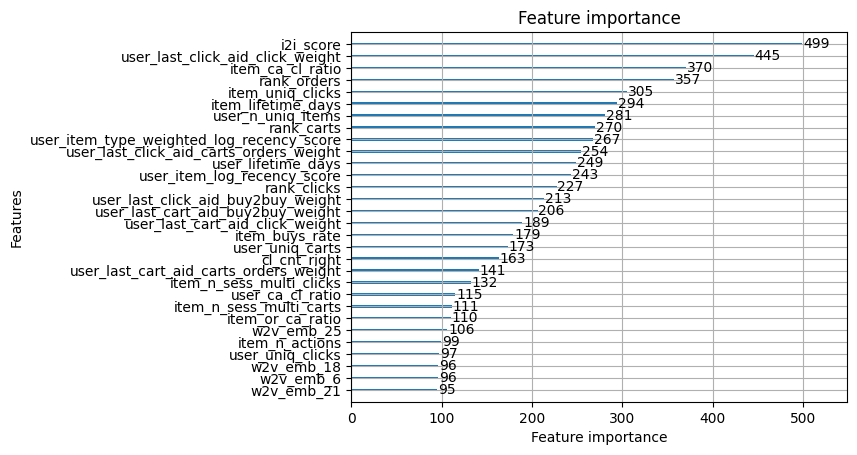

In [74]:
lgb.plot_importance(gbm_ranking, max_num_features=30)

#### candidates covisit top200 all types - orders, carts, clicks (CV orders 0.6551)
#### candidates covisit top200 all types - orders, carts, clicks + i2i top100 (CV orders 0.6557) BEST!
#### candidates covisit top200 all types - orders, carts, clicks + i2i top100, features item_time_distribution (CV orders 0.6557)

In [38]:
feature_cols = df_stage_2_dataset_train.drop(["session", "aid", "target"]).columns
feature_cols

['rank_orders',
 'rank_carts',
 'rank_clicks',
 'i2i_score',
 'user_last_click_aid_carts_orders_weight',
 'user_last_click_aid_buy2buy_weight',
 'user_last_click_aid_click_weight',
 'user_last_cart_aid_carts_orders_weight',
 'user_last_cart_aid_buy2buy_weight',
 'user_last_cart_aid_click_weight',
 'user_last_order_aid_carts_orders_weight',
 'user_last_order_aid_buy2buy_weight',
 'user_last_order_aid_click_weight',
 'user_lifetime_days',
 'user_n_actions',
 'user_n_uniq_items',
 'user_buys_rate',
 'user_uniq_clicks',
 'user_uniq_carts',
 'user_uniq_orders',
 'cl_cnt',
 'ca_cnt',
 'or_cnt',
 'user_ca_cl_ratio',
 'user_or_cl_ratio',
 'user_or_ca_ratio',
 'item_lifetime_days',
 'item_n_actions',
 'item_n_uniq_users',
 'item_buys_rate',
 'item_uniq_orders',
 'item_uniq_clicks',
 'item_uniq_carts',
 'or_cnt_right',
 'cl_cnt_right',
 'ca_cnt_right',
 'item_ca_cl_ratio',
 'item_or_cl_ratio',
 'item_or_ca_ratio',
 'item_n_sess_multi_clicks',
 'item_n_sess_multi_carts',
 'item_n_sess_multi_buys'

In [39]:
skf = GroupKFold(n_splits=5)
df_valid_preds = df_stage_2_dataset_train.select(["session", "aid"])

for fold, (train_idx, valid_idx) in tqdm(enumerate(
    skf.split(df_stage_2_dataset_train,
              df_stage_2_dataset_train['target'],
              groups=df_stage_2_dataset_train['session'])
)):
    
    X_train = df_stage_2_dataset_train[train_idx][feature_cols].to_pandas()
    y_train = df_stage_2_dataset_train[train_idx]["target"].to_pandas()
    X_valid = df_stage_2_dataset_train[valid_idx][feature_cols].to_pandas()
    y_valid = df_stage_2_dataset_train[valid_idx]["target"].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset_train[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset_train[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_numba_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    scores = gbm_ranking.predict(X_valid)
    df_valid_preds_fold = (
        df_stage_2_dataset_train[valid_idx].select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )
    
    # add save models
    gbm_ranking.save_model(f"__model__carts_covisit_all_types_merged_top200+i2i_k=100_top100_reranker_rank+i2i_score+42feat_fold{fold}.lgb")

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.809938
[40]	valid_0's numba_recall@20: 0.815305
[60]	valid_0's numba_recall@20: 0.818017
[80]	valid_0's numba_recall@20: 0.819152
[100]	valid_0's numba_recall@20: 0.820287
[120]	valid_0's numba_recall@20: 0.820788
[140]	valid_0's numba_recall@20: 0.821134
[160]	valid_0's numba_recall@20: 0.821192
[180]	valid_0's numba_recall@20: 0.821288
[200]	valid_0's numba_recall@20: 0.821442
[220]	valid_0's numba_recall@20: 0.821826
[240]	valid_0's numba_recall@20: 0.821692
[260]	valid_0's numba_recall@20: 0.821826
[280]	valid_0's numba_recall@20: 0.821345
[300]	valid_0's numba_recall@20: 0.821692
[320]	valid_0's numba_recall@20: 0.821692
[340]	valid_0's numba_recall@20: 0.821672
Early stopping, best iteration is:
[259]	valid_0's numba_recall@20: 0.821865


1it [04:47, 287.85s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.808882
[40]	valid_0's numba_recall@20: 0.815395
[60]	valid_0's numba_recall@20: 0.817286
[80]	valid_0's numba_recall@20: 0.818298
[100]	valid_0's numba_recall@20: 0.819673
[120]	valid_0's numba_recall@20: 0.820399
[140]	valid_0's numba_recall@20: 0.820571
[160]	valid_0's numba_recall@20: 0.820514
[180]	valid_0's numba_recall@20: 0.82101
[200]	valid_0's numba_recall@20: 0.8208
[220]	valid_0's numba_recall@20: 0.821068
[240]	valid_0's numba_recall@20: 0.821259
[260]	valid_0's numba_recall@20: 0.821221
[280]	valid_0's numba_recall@20: 0.821182
[300]	valid_0's numba_recall@20: 0.821431
[320]	valid_0's numba_recall@20: 0.821545
[340]	valid_0's numba_recall@20: 0.821507
[360]	valid_0's numba_recall@20: 0.821526
[380]	valid_0's numba_recall@20: 0.821545
[400]	valid_0's numba_recall@20: 0.821564
[420]	valid_0's numba_recall@20: 0.821545
Early stopping, best iteration is:
[325]	valid_0's numba_recall

2it [10:18, 313.23s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.807635
[40]	valid_0's numba_recall@20: 0.8132
[60]	valid_0's numba_recall@20: 0.815113
[80]	valid_0's numba_recall@20: 0.816834
[100]	valid_0's numba_recall@20: 0.817504
[120]	valid_0's numba_recall@20: 0.818326
[140]	valid_0's numba_recall@20: 0.818575
[160]	valid_0's numba_recall@20: 0.819034
[180]	valid_0's numba_recall@20: 0.81934
[200]	valid_0's numba_recall@20: 0.819531
[220]	valid_0's numba_recall@20: 0.819703
[240]	valid_0's numba_recall@20: 0.819875
[260]	valid_0's numba_recall@20: 0.820086
[280]	valid_0's numba_recall@20: 0.820086
[300]	valid_0's numba_recall@20: 0.820487
[320]	valid_0's numba_recall@20: 0.820526
[340]	valid_0's numba_recall@20: 0.820449
[360]	valid_0's numba_recall@20: 0.820602
[380]	valid_0's numba_recall@20: 0.820717
[400]	valid_0's numba_recall@20: 0.82064
[420]	valid_0's numba_recall@20: 0.820927
[440]	valid_0's numba_recall@20: 0.820946
[460]	valid_0's numba_

3it [17:35, 369.40s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.807115
[40]	valid_0's numba_recall@20: 0.811639
[60]	valid_0's numba_recall@20: 0.814341
[80]	valid_0's numba_recall@20: 0.815127
[100]	valid_0's numba_recall@20: 0.816641
[120]	valid_0's numba_recall@20: 0.81691
[140]	valid_0's numba_recall@20: 0.817581
[160]	valid_0's numba_recall@20: 0.817734
[180]	valid_0's numba_recall@20: 0.817734
[200]	valid_0's numba_recall@20: 0.817868
[220]	valid_0's numba_recall@20: 0.817753
[240]	valid_0's numba_recall@20: 0.817887
[260]	valid_0's numba_recall@20: 0.818002
[280]	valid_0's numba_recall@20: 0.818271
[300]	valid_0's numba_recall@20: 0.818405
[320]	valid_0's numba_recall@20: 0.818539
[340]	valid_0's numba_recall@20: 0.818635
[360]	valid_0's numba_recall@20: 0.818903
[380]	valid_0's numba_recall@20: 0.818712
[400]	valid_0's numba_recall@20: 0.818827
[420]	valid_0's numba_recall@20: 0.818577
[440]	valid_0's numba_recall@20: 0.818482
Early stopping, bes

4it [23:25, 361.93s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.805591
[40]	valid_0's numba_recall@20: 0.81147
[60]	valid_0's numba_recall@20: 0.814955
[80]	valid_0's numba_recall@20: 0.815854
[100]	valid_0's numba_recall@20: 0.81708
[120]	valid_0's numba_recall@20: 0.817367
[140]	valid_0's numba_recall@20: 0.817884
[160]	valid_0's numba_recall@20: 0.818095
[180]	valid_0's numba_recall@20: 0.818516
[200]	valid_0's numba_recall@20: 0.818669
[220]	valid_0's numba_recall@20: 0.818765
[240]	valid_0's numba_recall@20: 0.818803
[260]	valid_0's numba_recall@20: 0.818573
[280]	valid_0's numba_recall@20: 0.81865
[300]	valid_0's numba_recall@20: 0.818573
[320]	valid_0's numba_recall@20: 0.818459
Early stopping, best iteration is:
[230]	valid_0's numba_recall@20: 0.818995


5it [27:50, 334.03s/it]


In [40]:
_ = calc_oof_score_for_type(df_valid_preds, act_type="carts")

100%|██████████| 265206/265206 [00:00<00:00, 268890.38it/s]


validation score: 0.12400738011653017
recall per type: type
carts   0.4134
dtype: float64


In [127]:
_ = calc_oof_score_for_type(df_valid_preds, act_type="orders")

100%|██████████| 134666/134666 [00:00<00:00, 273507.61it/s]


validation score: 0.3934185330114062
recall per type: type
orders   0.6557
dtype: float64


In [51]:
0.1 * 0.5155 + 0.3 * 0.4134 + 0.6 * 0.6557 + 0.0206

0.5895899999999998

# OVERALL METRICS

In [183]:
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked_all, topk=20)

validation score: 0.5664316451092883
recall per type: type
carts    0.4114
clicks   0.5155
orders   0.6525
dtype: float64


In [9]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6430 + 0.0206

0.5813699999999999

In [4]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6525 + 0.0206

0.5870699999999999

In [53]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6539 + 0.0206

0.5879099999999999

In [101]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6551 + 0.0206

0.58863

In [100]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6557 + 0.0206

0.5889899999999999

In [109]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6557 + 0.0206

0.5889899999999999